In [1]:
# PKG Tensorflow keras 
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D,  LSTM, Flatten, MaxPooling1D
from tensorflow.keras.models import Sequential
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer

# PKG Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelBinarizer

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import pickle
import joblib

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

%matplotlib inline



In [2]:
with open('data/data_clean.pkl', 'rb') as f:
    my_unpickle = pickle.Unpickler(f)
    data = my_unpickle.load()

In [3]:
data.shape

(471149, 16)

In [4]:
#data.macromoleculeType.value_counts()

In [5]:
# macromoleculeType
macro_molec = ['Protein', 'Protein#RNA', 'Protein#DNA']

types_macro = {}
macro_percent = (data.macromoleculeType.value_counts(normalize=True)*100).index.tolist()

for macro in macro_percent:
    if macro not in macro_molec:
        types_macro[macro] = "others_macro_mol"
    else:
        types_macro[macro] = macro
        
data.macromoleculeType = data.macromoleculeType.map(types_macro)

In [6]:
round(data.classification.value_counts()/data.classification.shape[0]*100,3)[:50]

ribosome                                   12.886
hydrolase                                  10.152
transferase                                 8.007
oxidoreductase                              7.453
immune system                               3.394
hydrolase/hydrolase inhibitor               2.862
lyase                                       2.520
virus                                       2.299
transcription                               2.242
ribosome/antibiotic                         2.209
viral protein                               1.884
transport protein                           1.858
isomerase                                   1.404
signaling protein                           1.394
structural genomics/unknown function        1.181
ligase                                      1.086
protein binding                             1.077
membrane protein                            1.046
transferase/transferase inhibitor           0.973
chaperone                                   0.936


#### Les raisons d'un choix 

4 classes équilibrées representant  37% du dataset, nous avons fait le choix de limiter le dataset aux classes ayant une fréquence >= à 5000, le tout répresentant 63,9% du dataset

In [7]:
class_dict = dict()
count = 0

classes = data['classification'].value_counts().items()

for cat, num in classes:
    
    
    #if num < 1000:
     #   temp = data['classification'] == cat
      #  data = data[~temp].copy()
      #  continue
        
        
        
    if num >= 5000:
        class_dict[cat] = count
        count += 1

In [8]:
class_dict

{'ribosome': 0,
 'hydrolase': 1,
 'transferase': 2,
 'oxidoreductase': 3,
 'immune system': 4,
 'hydrolase/hydrolase inhibitor': 5,
 'lyase': 6,
 'virus': 7,
 'transcription': 8,
 'ribosome/antibiotic': 9,
 'viral protein': 10,
 'transport protein': 11,
 'isomerase': 12,
 'signaling protein': 13,
 'structural genomics/unknown function': 14,
 'ligase': 15,
 'protein binding': 16}

In [9]:
data['classification'] = data['classification'].map(class_dict)

In [31]:
# check missing values 

pd.DataFrame({'Total': data.isna().sum(),
             'Percent': data.isna().sum()/data.shape[0],
             'Types': data.dtypes})

,Total,Percent,Types
structureId,0,0.000000,object
classification,170050,0.360926,float64
experimentalTechnique,0,0.000000,object
macromoleculeType,35770,0.075921,object
residueCount,0,0.000000,int64
resolution,21663,0.045979,float64
structureMolecularWeight,0,0.000000,float64
crystallizationMethod,156395,0.331944,object
crystallizationTempK,153452,0.325697,float64
densityMatthews,81504,0.172990,float64


In [10]:
data = data.loc[:, ['classification', 'sequence']]

In [11]:
data.shape

(471149, 2)

In [12]:
data.isnull().sum()

classification    170050
sequence              28
dtype: int64

In [13]:
round(data.classification.value_counts()/data.classification.shape[0]*100,3)

0.0     12.886
1.0     10.152
2.0      8.007
3.0      7.453
4.0      3.394
5.0      2.862
6.0      2.520
7.0      2.299
8.0      2.242
9.0      2.209
10.0     1.884
11.0     1.858
12.0     1.404
13.0     1.394
14.0     1.181
15.0     1.086
16.0     1.077
Name: classification, dtype: float64

In [14]:
data = data.dropna()

In [15]:
data.shape

(301097, 2)

In [16]:
# Transformation des labels en one hot 
lb = LabelBinarizer()
Y = lb.fit_transform(data.classification)

In [17]:
data.describe(include = 'O')

,sequence
count,301097
unique,61547
top,PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEG...
freq,5112


In [18]:
max_length = 512 # dim_seq maximale
seqs = data.sequence.values
#créer un tokenizer et l'entrainer 
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#representation de la variable explicative en sequence des nombres 
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)

In [40]:
ldata.sequence.max())

3

In [19]:
X.shape

(301097, 512)

In [20]:
X[:3]

array([[0, 0, 0, ..., 1, 6, 4],
       [0, 0, 0, ..., 1, 6, 4],
       [0, 0, 0, ..., 6, 3, 3]])

In [21]:
from keras.layers import BatchNormalization
from keras.layers import Dropout, Activation
#from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.layers as layers
from keras import regularizers
import keras.models as models
from tensorflow.keras.utils import plot_model
import pydot 
import graphviz 

#### CNN1 With Batch Normalization 

In [28]:
embedding_dim = 8
numb_classes = 17

model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=6, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(numb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

#es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 8)            208       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 512, 64)           3136      
_________________________________________________________________
activation_3 (Activation)    (None, 512, 64)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 64)           256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 256, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 256, 32)           6176      
_________________________________________________________________
activation_4 (Activation)    (None, 256, 32)          

In [26]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'

In [27]:
plot_model(model, 'model.png' ,show_shapes=True)

InvocationException: GraphViz's executables not found

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((210767, 512), (90330, 512), (210767, 17), (90330, 17))

In [30]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128)

Epoch 1/20
1647/1647 [==============================] - 710s 431ms/step - loss: 0.9757 - accuracy: 0.7099 - val_loss: 0.6782 - val_accuracy: 0.7995
Epoch 2/20
1647/1647 [==============================] - 761s 462ms/step - loss: 0.5246 - accuracy: 0.8394 - val_loss: 0.5951 - val_accuracy: 0.8269
Epoch 3/20
1647/1647 [==============================] - 909s 552ms/step - loss: 0.3993 - accuracy: 0.8730 - val_loss: 0.7315 - val_accuracy: 0.7950
Epoch 4/20
1647/1647 [==============================] - 897s 545ms/step - loss: 0.3354 - accuracy: 0.8899 - val_loss: 0.5399 - val_accuracy: 0.8510
Epoch 5/20
1647/1647 [==============================] - 748s 454ms/step - loss: 0.2997 - accuracy: 0.8992 - val_loss: 0.5160 - val_accuracy: 0.8622
Epoch 6/20
1647/1647 [==============================] - 692s 420ms/step - loss: 0.2750 - accuracy: 0.9062 - val_loss: 0.5276 - val_accuracy: 0.8695
Epoch 7/20
1647/1647 [==============================] - 682s 414ms/step - loss: 0.2566 - accuracy: 0.9111 - val_

In [24]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train-acc = 0.9314883259713332
test-acc = 0.8816561496734197


In [34]:
model.evaluate(X_train, y_train)

6587/6587 [==============================] - 112s 17ms/step - loss: 0.1753 - accuracy: 0.9332


[0.17530027031898499, 0.9332058429718018]

In [35]:
model.evaluate(X_test, y_test)

2823/2823 [==============================] - 51s 18ms/step - loss: 0.5708 - accuracy: 0.8822


[0.5708385109901428, 0.8821986317634583]

In [50]:
#print('Predicted: %s (class=%d)' % (test_pred, np.argmax(test_pred)))

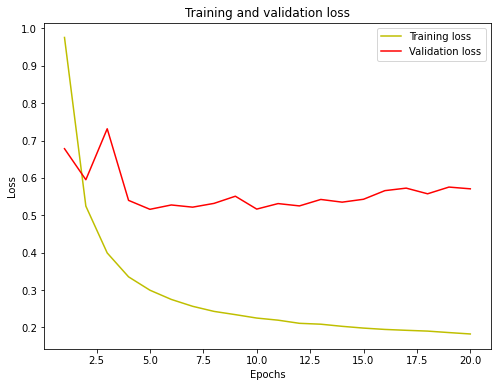

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

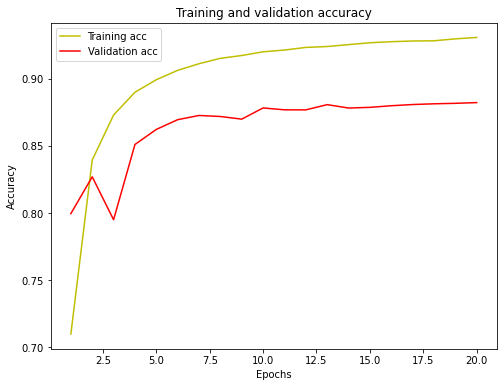

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

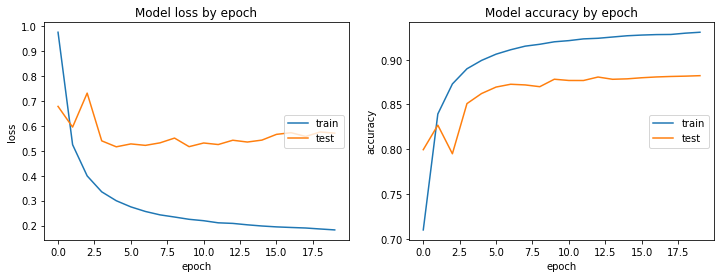

In [33]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [29]:
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(test_pred, axis = 1), target_names = class_dict))

                                      precision    recall  f1-score   support

                            ribosome       0.85      0.99      0.91     18310
                           hydrolase       0.89      0.86      0.87     14457
                         transferase       0.91      0.93      0.92     11174
                      oxidoreductase       0.95      0.96      0.96     10509
                       immune system       0.93      0.93      0.93      4813
       hydrolase/hydrolase inhibitor       0.74      0.81      0.77      3951
                               lyase       0.94      0.94      0.94      3545
                               virus       0.97      0.97      0.97      3285
                       transcription       0.83      0.84      0.83      3153
                 ribosome/antibiotic       0.62      0.05      0.09      3032
                       viral protein       0.90      0.89      0.90      2710
                   transport protein       0.89      0.88      

In [56]:
y_test = np.argmax(y_test, axis = 1)
test_pred = np.argmax(test_pred, axis = 1)

#### Saving Model 

In [41]:
from keras.models import save_model, load_model

In [43]:
filename = 'data/model_deep_cnn1.pkl'
save_model(model, filename)

INFO:tensorflow:Assets written to: data/model_deep_cnn1.pkl\assets


In [44]:
model = load_model(filename)

In [48]:
model.predict(X_test)[2]

array([1.8208469e-11, 5.1389420e-01, 7.8018939e-11, 3.2885203e-09,
       2.5605012e-13, 4.8606804e-01, 1.2118166e-08, 9.7390859e-11,
       2.1805504e-06, 6.1855021e-14, 6.6741258e-08, 1.9746454e-11,
       5.2598384e-11, 5.7477742e-08, 1.8852184e-08, 1.2168825e-11,
       3.5391586e-05], dtype=float32)

In [51]:
model.predict(X_train)[2]

array([7.75293171e-01, 3.14572901e-07, 2.10152802e-08, 3.39066081e-10,
       2.99162001e-10, 3.30719868e-10, 2.14371187e-09, 3.13906817e-10,
       1.19277836e-04, 2.24532858e-01, 2.06986921e-13, 3.36822019e-08,
       1.86849193e-05, 9.23397252e-08, 3.08619783e-05, 3.42916664e-08,
       4.57563647e-06], dtype=float32)

#### LSTM 

In [86]:


embedding_dim = 8
lstm_out = 128
batch_size = 128
top_classes = 17

model1 = Sequential()
model1.add(Embedding(len(tokenizer.word_index)+1, 8))
model1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(top_classes,activation='softmax'))
model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model1.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 8)           208       
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_5 (Dense)              (None, 17)                2193      
Total params: 72,545
Trainable params: 72,545
Non-trainable params: 0
_________________________________________________________________
None


In [88]:
history_lstm = model1.fit(X_train, y_train, epochs=5, batch_size =128, validation_data=(X_test, y_test))

Epoch 1/5
1647/1647 [==============================] - ETA: 0s - loss: 2.2903 - accuracy: 0.2862 

ValueError: in user code:

    C:\Users\SAFA PC\anaconda3\lib\site-packages\keras\engine\training.py:1330 test_function  *
        return step_function(self, iterator)
    C:\Users\SAFA PC\anaconda3\lib\site-packages\keras\engine\training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\SAFA PC\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\SAFA PC\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\SAFA PC\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\SAFA PC\anaconda3\lib\site-packages\keras\engine\training.py:1313 run_step  **
        outputs = model.test_step(data)
    C:\Users\SAFA PC\anaconda3\lib\site-packages\keras\engine\training.py:1269 test_step
        self.compiled_loss(
    C:\Users\SAFA PC\anaconda3\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\SAFA PC\anaconda3\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\SAFA PC\anaconda3\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\SAFA PC\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\SAFA PC\anaconda3\lib\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\SAFA PC\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\SAFA PC\anaconda3\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\SAFA PC\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 17) are incompatible


In [ ]:
train_pred = model_lstm.predict(X_train)
test_pred = model_lstm.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

In [ ]:
loss = history_lstm.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']
plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(121)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()